# Set of codes by; SebastianMantey/Decision-Tree-from-Scratch

# Classification Example

## Continuous on Iris DataSet

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("./iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})

df.head()
#df.info()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [4]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=20)

In [5]:
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

## Purity 

In [6]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [7]:
check_purity(train_df[train_df.petal_width < 0.8].values)

True

## Classification

In [8]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

## Will it split?

In [9]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [10]:
potential_splits = get_potential_splits(train_df.values)

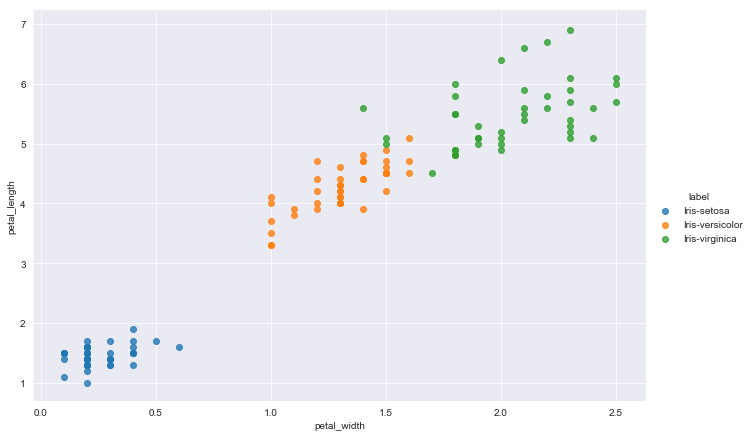

In [11]:
sns.lmplot(data=train_df, x="petal_width", y="petal_length", hue="label", 
           fit_reg=False, height=6, aspect=1.5 )
#plt.vlines(x=potential_splits[3], ymin=1,ymax=7)
#plt.hlines(y=potential_splits[2], xmin=0,xmax=2.5)

## Split data 

In [12]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

## Lowest Overall Entropy

In [13]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [14]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [15]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

# Decision Tree Algorithm

In [16]:
sub_tree = {"question": ["yes_answer", 
                         "no_answer"]}

In [17]:
example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
                                      {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor", 
                                                                                        "Iris-virginica"]}, 
                                                                "Iris-virginica"]}]}

In [18]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [19]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [20]:
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.6': [{'petal_length <= 4.9': ['Iris-versicolor',
                                                                         'Iris-virginica']},
                                                'Iris-virginica']}]}


In [21]:
sub_tree

{'question': ['yes_answer', 'no_answer']}

In [22]:
example = test_df.iloc[0]
example

sepal_length                5.1
sepal_width                 2.5
petal_length                  3
petal_width                 1.1
label           Iris-versicolor
Name: 98, dtype: object

In [23]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [24]:
classify_example(example, tree)

'Iris-versicolor'

In [25]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [26]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.95

# With categorical data

# Titanic Dataset

In [27]:
df = pd.read_csv("./Titanic.csv")
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

df = df.fillna({"Age": median_age, "Embarked": mode_embarked})

In [28]:
random.seed(0)

train_df, test_df = train_test_split(df, 0.2)
tree = decision_tree_algorithm(train_df, max_depth=10)
accuracy = calculate_accuracy(test_df, tree)

pprint(tree, width=50)
accuracy

{'Sex = female': [{'Pclass = 2': [{'Fare <= 28.7125': [{'Fare <= 27.75': [{'Age <= 23.0': [1,
                                                                                           {'Age <= 55.0': [{'Age <= 26.0': [{'Age <= 25.0': [{'Fare <= 13.0': [0,
                                                                                                                                                                1]},
                                                                                                                                              0]},
                                                                                                                             {'Age <= 36.0': [1,
                                                                                                                                              {'Age <= 38.0': [0,
                                                                                                                            

0.6797752808988764